In [71]:
import os
import csv
from collections import defaultdict, Counter
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, mannwhitneyu
import math

In [2]:
LOGS = '/mnt/data0/lucy/gpt3_bias/logs/'
prompts_path = LOGS + 'original_prompts/'

## Character name popularity

In [5]:
def get_named_entities(char_neighbor_path): 
    '''
    Count named entities once per story
    '''
    named_people = Counter()
    for f in os.listdir(char_neighbor_path):
        all_people = set()
        with open(char_neighbor_path + f, 'r') as infile: 
            char_neighbors = json.load(infile)
        for char in char_neighbors: 
            neighbor_dict = char_neighbors[char]
            for neighbor in neighbor_dict: 
                all_people.add(neighbor['character_name'])
                for al in neighbor['aliases']: 
                    all_people.add(al)
        for person in all_people: 
            name = '_'.join(person.split('_')[:-1])
            named_people[name] += 1
    return named_people

In [4]:
def plot_popular_names(char_neighbor_path, title): 
    plt.figure(dpi=150, figsize=(6,6))
    people = get_named_entities(char_neighbor_path)
    total_names = sum(list(people.values()))
    labels = []
    values = []
    for tup in people.most_common(20): 
        labels.append(tup[0])
        values.append(tup[1]/total_names)
    labels = labels[::-1]
    values = values[::-1]
    x = np.arange(len(labels))
    plt.barh(x, values, 0.7)
    plt.xlabel('Percentage of names')
    plt.title(title)
    plt.yticks(x, labels=labels, fontsize=12)
    plt.show()

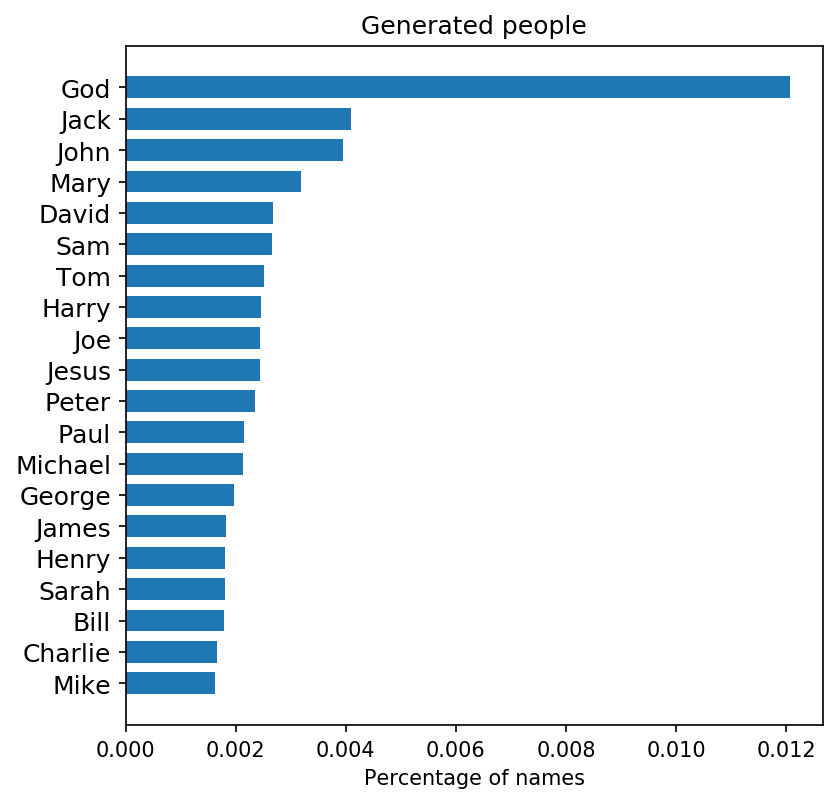

In [5]:
plot_popular_names(LOGS + 'char_neighbors_0.9/', 'Generated people')

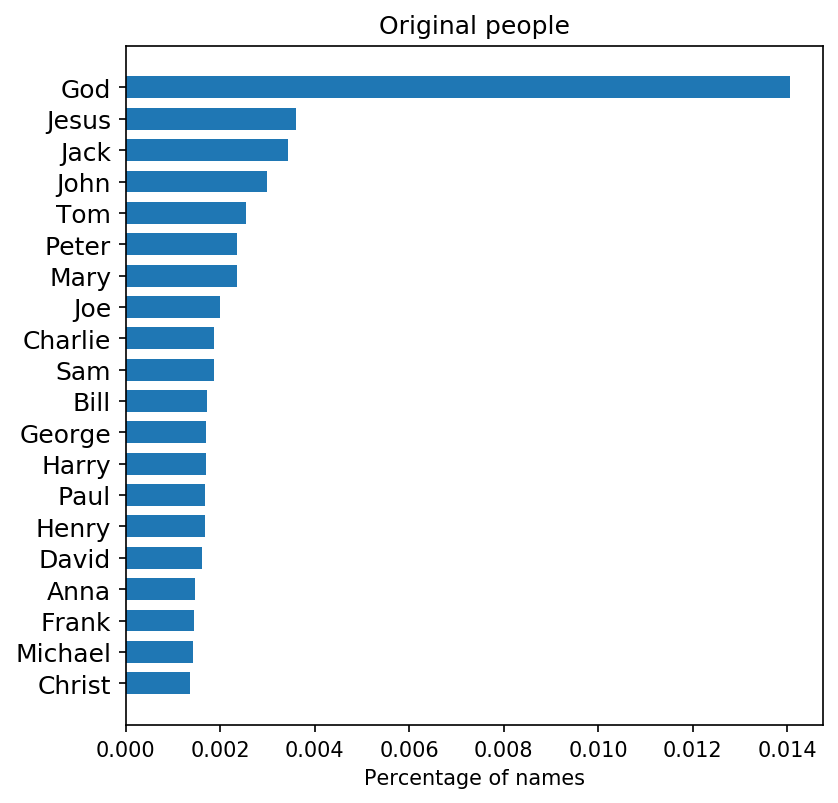

In [6]:
plot_popular_names(LOGS + 'orig_char_neighbors/', 'Original people')

## Character networks

In [342]:
def get_char_network(char_neighbor_path): 
    # gender type is "name" or "pronouns"
    d = {'main_gender':[], 'fem count':[], 'masc count':[], 'mixed pronouns count':[], 
        'other (name) count': [], 'masc (name) count': [], 'fem (name) count': []}
    all_n_genders = ['mixed pronouns', 'other (name)', 'masc (name)', 'fem (name)', 'fem', 'masc']
    for title in os.listdir(prompts_path): 
        if not os.path.exists(char_neighbor_path + title + '.json'): continue
        with open(char_neighbor_path + title + '.json', 'r') as infile: 
            char_neighbors = json.load(infile)
        for char in char_neighbors: 
            # for every main character
            main_char_gender = defaultdict(str) # story ID to gender
            neighbor_dict = char_neighbors[char]
            neighbor_genders = defaultdict(list) # story ID to neighbor genders
            for neighbor in neighbor_dict: 
                # for every character it co-occurs with 
                gender = neighbor['gender_label']
                neighbor_n = neighbor['character_name']
                pronoun_count = len(neighbor['gender'])
                story_ID = int(neighbor_n.split('_')[-1])
                is_main = False
                if neighbor_n.startswith(char + '_'): 
                    # main character
                    is_main = True
                else: 
                    for al in neighbor['aliases']: 
                        if al == char: 
                            is_main = True
                if is_main: 
                    if gender.startswith('mixed') or gender.startswith('other'): 
                        gender = 'other'
                    main_char_gender[story_ID] = gender
                    continue
                    
                if pronoun_count == 0 and not gender.endswith('(name)'): 
                    gender += ' (name)'
                neighbor_genders[story_ID].append(gender)
                
            for story_ID in main_char_gender: 
                main_g = main_char_gender[story_ID]
                n_genders = Counter(neighbor_genders[story_ID])
                total = sum(list(n_genders.values()))
                if total == 0: continue
                d['main_gender'].append(main_g)
                for gender in all_n_genders: 
                    d[gender + ' count'].append(n_genders[gender])
    return d

In [343]:
gen_d = get_char_network(LOGS + 'char_gender_0.9/')
gen_df = pd.DataFrame.from_dict(gen_d)
gen_stats = gen_df.groupby(['main_gender']).agg(['mean', 'count', 'std'])
gen_df

,main_gender,fem count,masc count,mixed pronouns count,other (name) count,masc (name) count,fem (name) count
0,other,1,2,0,0,2,1
1,masc,1,0,0,0,0,0
2,masc,0,2,0,2,2,4
3,other,0,5,0,3,1,1
4,other,1,1,0,0,1,0
...,...,...,...,...,...,...,...
103117,masc,1,3,0,2,0,0
103118,fem,0,0,0,1,0,0
103119,fem,0,5,0,2,3,3
103120,fem,4,3,0,2,0,2


In [344]:
orig_d = get_char_network(LOGS + 'orig_char_gender/')
orig_df = pd.DataFrame.from_dict(orig_d)
orig_stats = orig_df.groupby(['main_gender']).agg(['mean', 'count', 'std'])
orig_df

,main_gender,fem count,masc count,mixed pronouns count,other (name) count,masc (name) count,fem (name) count
0,other,6,4,1,1,4,0
1,other,0,2,1,5,3,2
2,other,2,0,1,1,0,0
3,other,1,2,0,0,0,0
4,other,5,0,1,1,2,2
...,...,...,...,...,...,...,...
21440,fem,1,2,1,0,3,0
21441,fem,2,2,0,1,1,5
21442,fem,2,2,1,0,2,3
21443,fem,1,2,1,0,3,1


In [357]:
orig_stats

fem count                  masc count                   \
                 mean  count       std       mean  count       std   
main_gender                                                          
fem          1.579833   6714  1.446381   2.247096   6714  1.616017   
masc         1.163596  13081  1.262125   2.427949  13081  1.708996   
other        1.241818   1650  1.222022   2.213939   1650  1.643754   

            mixed pronouns count                  other (name) count         \
                            mean  count       std               mean  count   
main_gender                                                                   
fem                     0.233393   6714  0.510470           1.044087   6714   
masc                    0.198685  13081  0.464045           1.137528  13081   
other                   0.338182   1650  0.589629           1.106061   1650   

                      masc (name) count                  fem (name) count  \
                  std              mean  count       std             mean   
main_gender                                                                 
fem          1.364952           2.15922   6714  2.004122         1.433870   
masc         1.456862           2.58520  13081  2.195410         0.971180   
other        1.381336           2.12303   1650  2.044980         1.020606   

                              
             count       std  
main_gender                   
fem           6714  1.700813  
masc         13081  1.313949  
other         1650  1.313110

In [345]:
def get_values(gender, stats):
    '''
    gender is main character gender, such as 'fem', 'masc', or 'other'
    '''
    c = stats.loc[gender].loc['fem count'].loc['count']
    name_means = [stats.loc[gender].loc['masc (name) count'].loc['mean'], 
                  stats.loc[gender].loc['fem (name) count'].loc['mean'], 
                  stats.loc[gender].loc['other (name) count'].loc['mean']]
    name_ci = [stats.loc[gender].loc['masc (name) count'].loc['std'], 
                  stats.loc[gender].loc['fem (name) count'].loc['std'], 
                  stats.loc[gender].loc['other (name) count'].loc['std']]
    for i in range(len(labels)): 
        name_ci[i] = 1.96*name_ci[i]/math.sqrt(c)
    pronoun_means = [stats.loc[gender].loc['masc count'].loc['mean'], 
                     stats.loc[gender].loc['fem count'].loc['mean'], 
                     stats.loc[gender].loc['mixed pronouns count'].loc['mean']]
    pronoun_ci = [stats.loc[gender].loc['masc count'].loc['std'], 
                     stats.loc[gender].loc['fem count'].loc['std'], 
                     stats.loc[gender].loc['mixed pronouns count'].loc['std']]
    for i in range(len(labels)): 
        pronoun_ci[i] = 1.96*pronoun_ci[i]/math.sqrt(c)
    return name_means, name_ci, pronoun_means, pronoun_ci

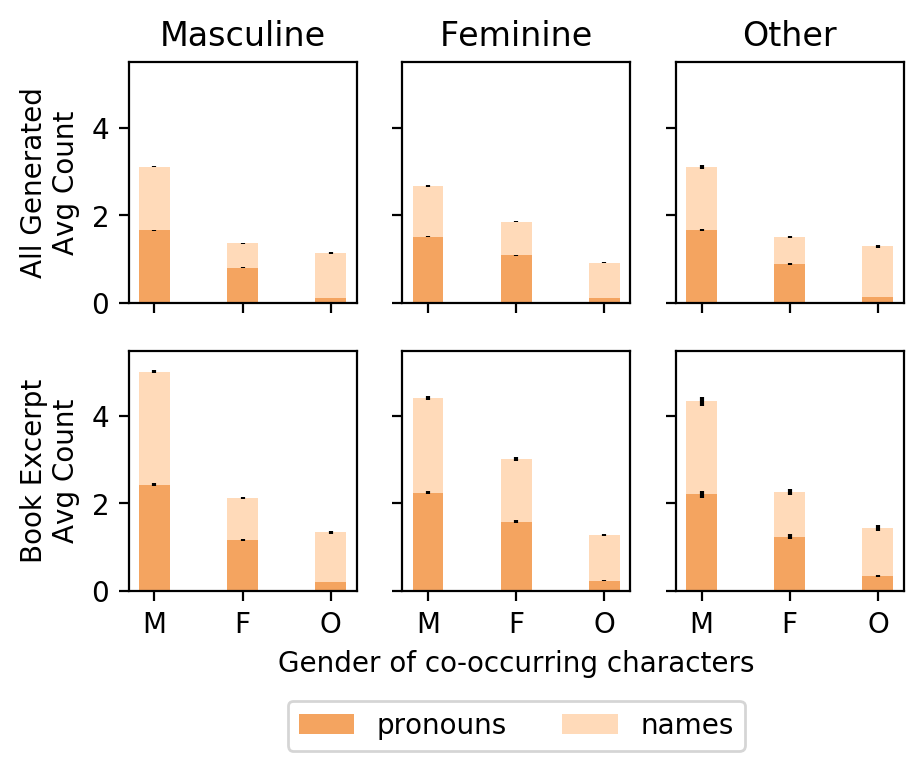

In [346]:
# https://matplotlib.org/3.3.3/gallery/lines_bars_and_markers/bar_stacked.html
fig, axes = plt.subplots(2, 3, figsize=(5, 3.5), dpi=200)
bar_width = 0.35
for i in range(2): 
    for j in range(3): 
        axes[i][j].set_ylim(0, 5.5)
labels = ['M', 'F', 'O']

name_means, name_ci, pronoun_means, pronoun_ci = get_values('masc', gen_stats)
axes[0][0].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[0][0].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')
axes[0][0].set_ylabel('All Generated\nAvg Count')
axes[0][0].set_title('Masculine')
axes[0][0].get_xaxis().set_ticklabels([])

name_means, name_ci, pronoun_means, pronoun_ci = get_values('fem', gen_stats)
axes[0][1].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[0][1].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')
axes[0][1].get_yaxis().set_ticklabels([])
axes[0][1].set_title('Feminine')
axes[0][1].get_xaxis().set_ticklabels([])

name_means, name_ci, pronoun_means, pronoun_ci = get_values('other', gen_stats)
axes[0][2].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[0][2].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')
axes[0][2].get_yaxis().set_ticklabels([])
axes[0][2].set_title('Other')
axes[0][2].get_xaxis().set_ticklabels([])

name_means, name_ci, pronoun_means, pronoun_ci = get_values('masc', orig_stats)
axes[1][0].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[1][0].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')
axes[1][0].set_ylabel('Book Excerpt\nAvg Count')

name_means, name_ci, pronoun_means, pronoun_ci = get_values('fem', orig_stats)
axes[1][1].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[1][1].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')
axes[1][1].get_yaxis().set_ticklabels([])
axes[1][1].set_xlabel('Gender of co-occurring characters')
axes[1][1].legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.4))

name_means, name_ci, pronoun_means, pronoun_ci = get_values('other', orig_stats)
axes[1][2].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[1][2].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')
axes[1][2].get_yaxis().set_ticklabels([])

plt.show()

In [347]:
# main character genders
print("Women:", gen_d['main_gender'].count('fem'), gen_d['main_gender'].count('fem')/len(gen_d['main_gender']))
print("Men:", gen_d['main_gender'].count('masc'), gen_d['main_gender'].count('masc')/len(gen_d['main_gender']))
print("Other:", gen_d['main_gender'].count('other'), gen_d['main_gender'].count('other')/len(gen_d['main_gender']))
print("Total:", len(gen_d['main_gender']))

Women: 32527 0.31542250926087545
Men: 57822 0.5607144935125385
Other: 12773 0.12386299722658599
Total: 103122


In [348]:
# main character genders
print("Women:", orig_d['main_gender'].count('fem'), orig_d['main_gender'].count('fem')/len(orig_d['main_gender']))
print("Men:", orig_d['main_gender'].count('masc'), orig_d['main_gender'].count('masc')/len(orig_d['main_gender']))
print("Other:", orig_d['main_gender'].count('other'), orig_d['main_gender'].count('other')/len(orig_d['main_gender']))
print("Total:", len(orig_d['main_gender']))

Women: 6714 0.3130799720214502
Men: 13081 0.6099790160876661
Other: 1650 0.07694101189088366
Total: 21445


## Topics

In [349]:
def get_topic_by_dataset():
    topic_dir = LOGS + 'topics_0.9'
    doc_topic_file = '%s/doc-topics.gz' % topic_dir
    doc_topics = open(doc_topic_file).read().splitlines() # list of topics
    story_ids = open(topic_dir + '/story_id_order').read().splitlines() # story IDs 
    data_topics = {'dataset':[], 'topic':[], 'value':[]}
    for i, doc in enumerate(doc_topics): 
        contents = doc.split('\t')
        topics = [float(i) for i in contents[2:]]
        story_title_id = story_ids[i]             
        assert len(topics) == 50
        for topic_id, value in enumerate(topics): 
            if story_title_id.startswith('ORIG_'):
                data_topics['dataset'].append('original')
            else: 
                data_topics['dataset'].append('generated')
            data_topics['topic'].append(topic_id)
            data_topics['value'].append(value)
    return data_topics

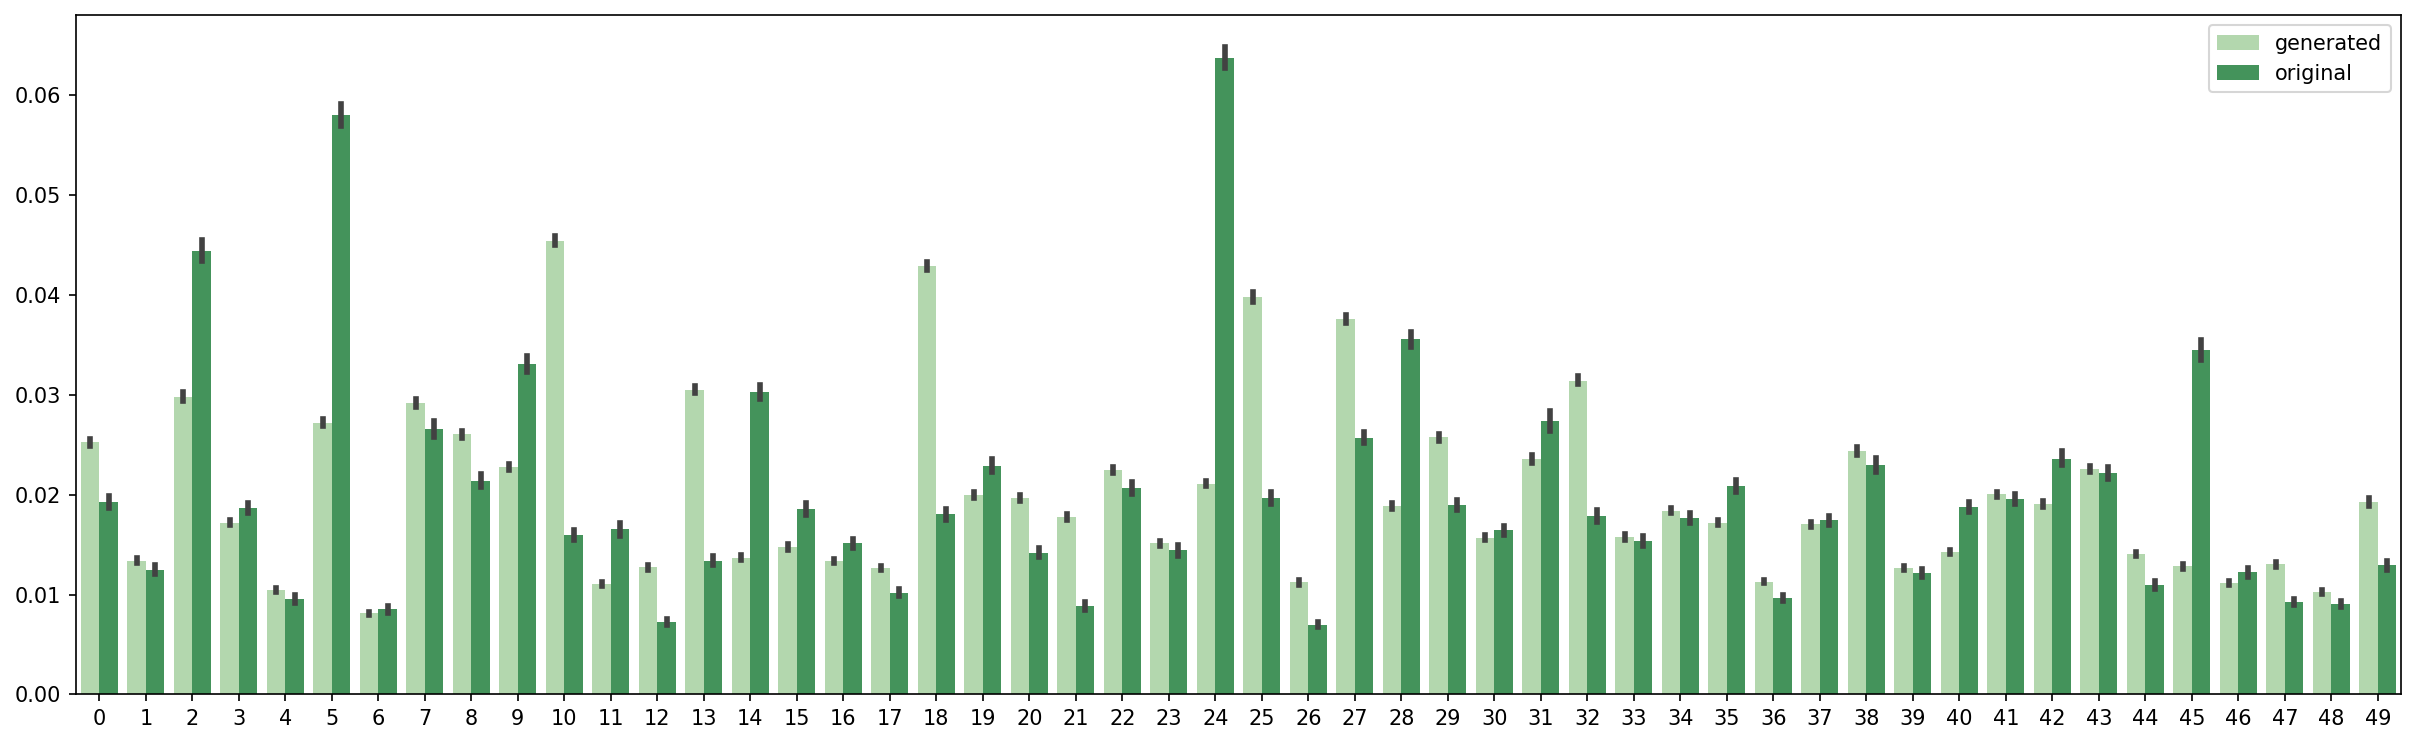

In [315]:
data_topics = get_topic_by_dataset()
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Greens", hue="dataset", data=data_topics)

In [350]:
with open(LOGS + 'gender_topics_0.9.json', 'r') as infile: 
    gen_gender_topics = json.load(infile)
with open(LOGS + 'orig_gender_topics.json', 'r') as infile: 
    orig_gender_topics = json.load(infile)
with open(LOGS + 'gender_topics_0.9_matched.json', 'r') as infile: 
    matched_gender_topics = json.load(infile)

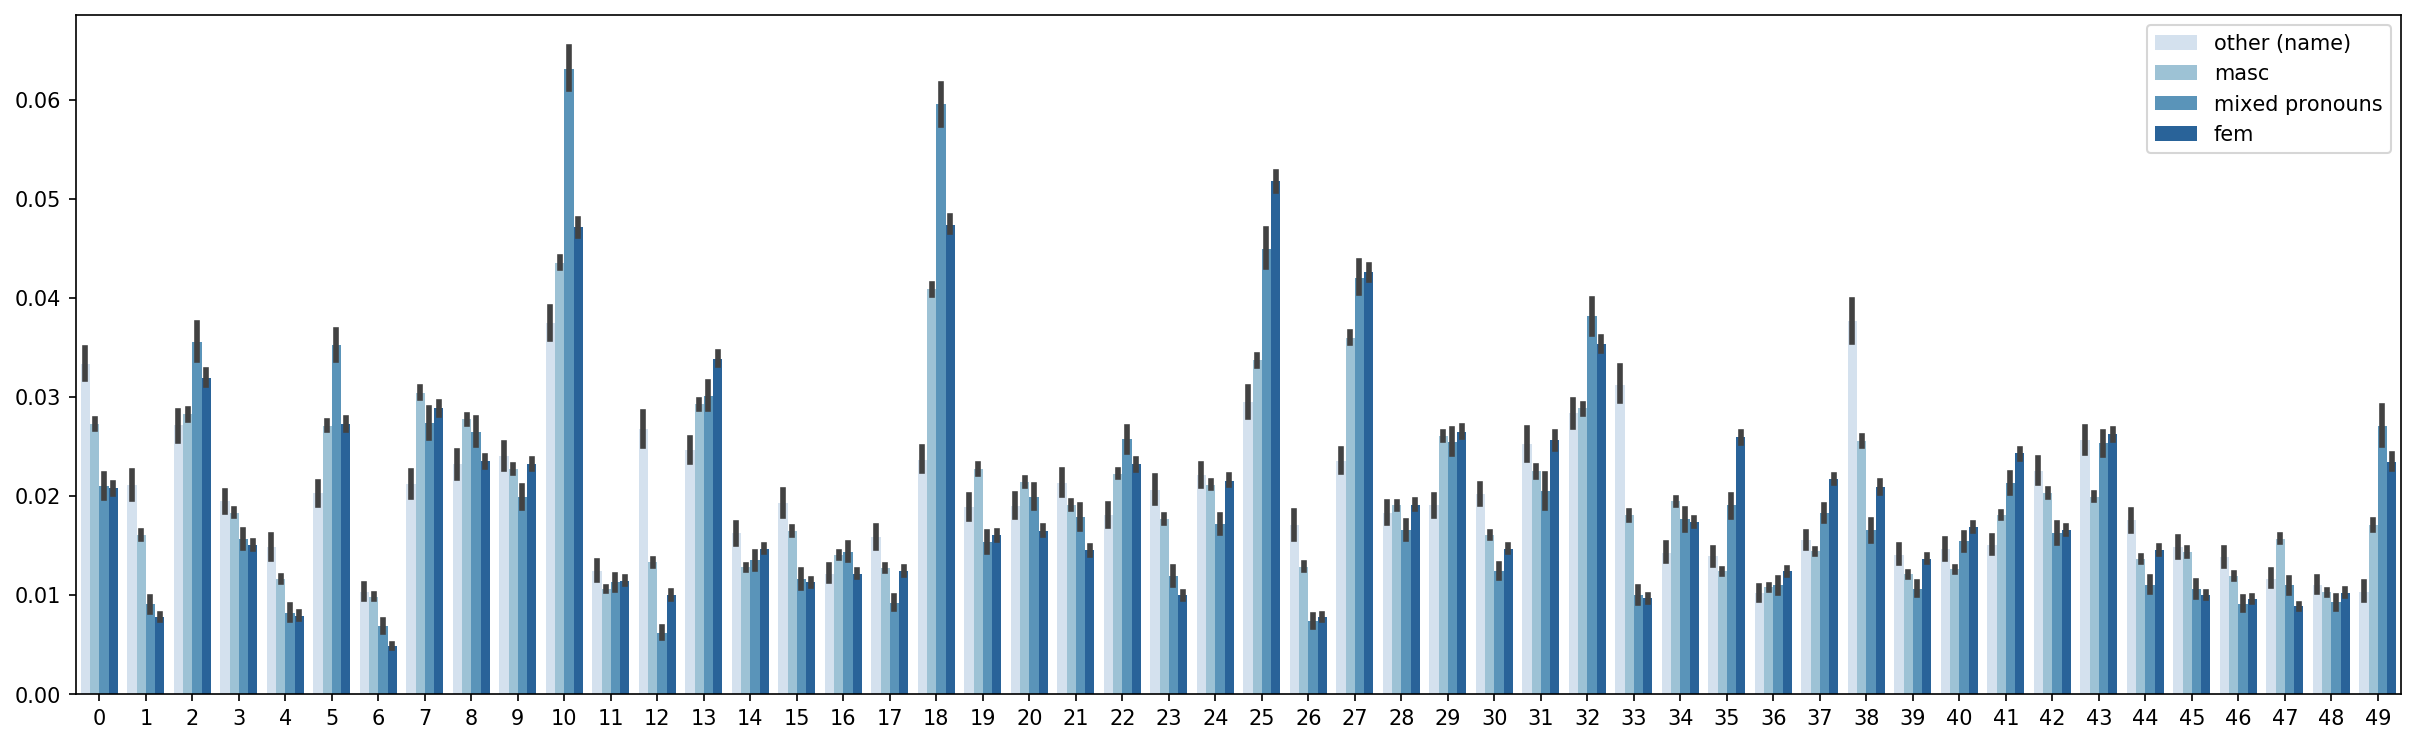

In [317]:
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Blues", hue="gender", data=gen_gender_topics)

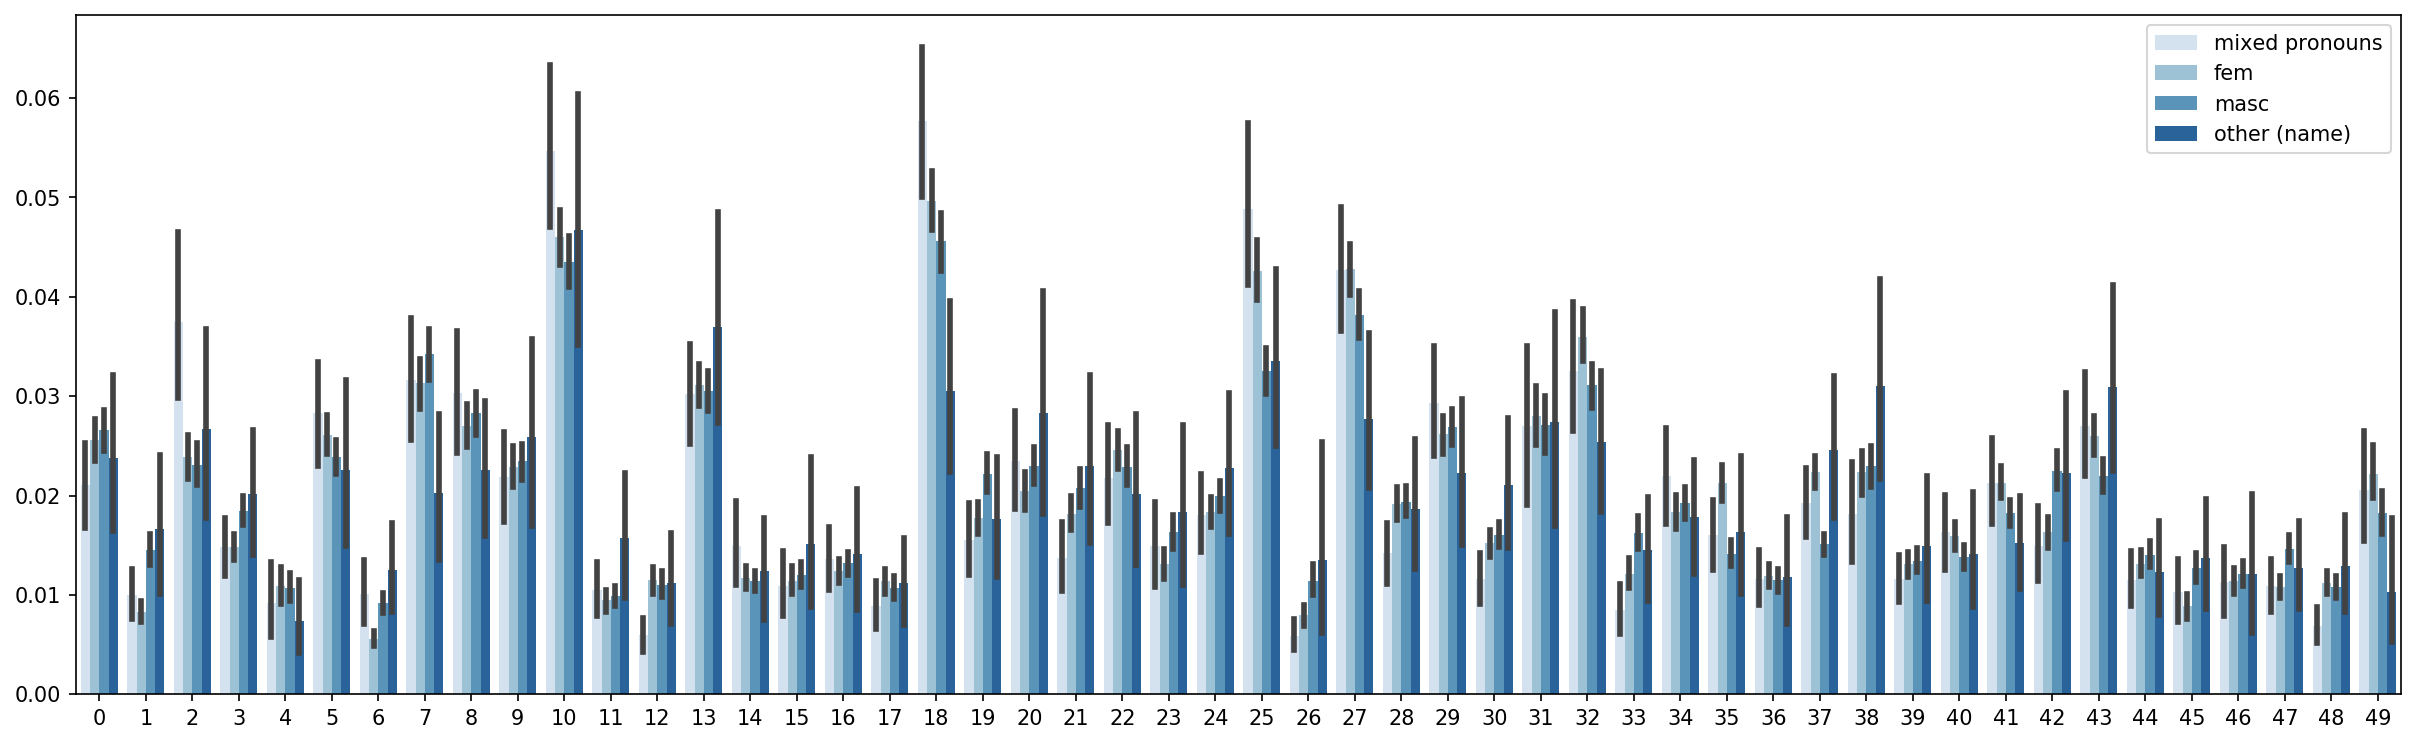

In [318]:
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Blues", hue="gender", data=matched_gender_topics)

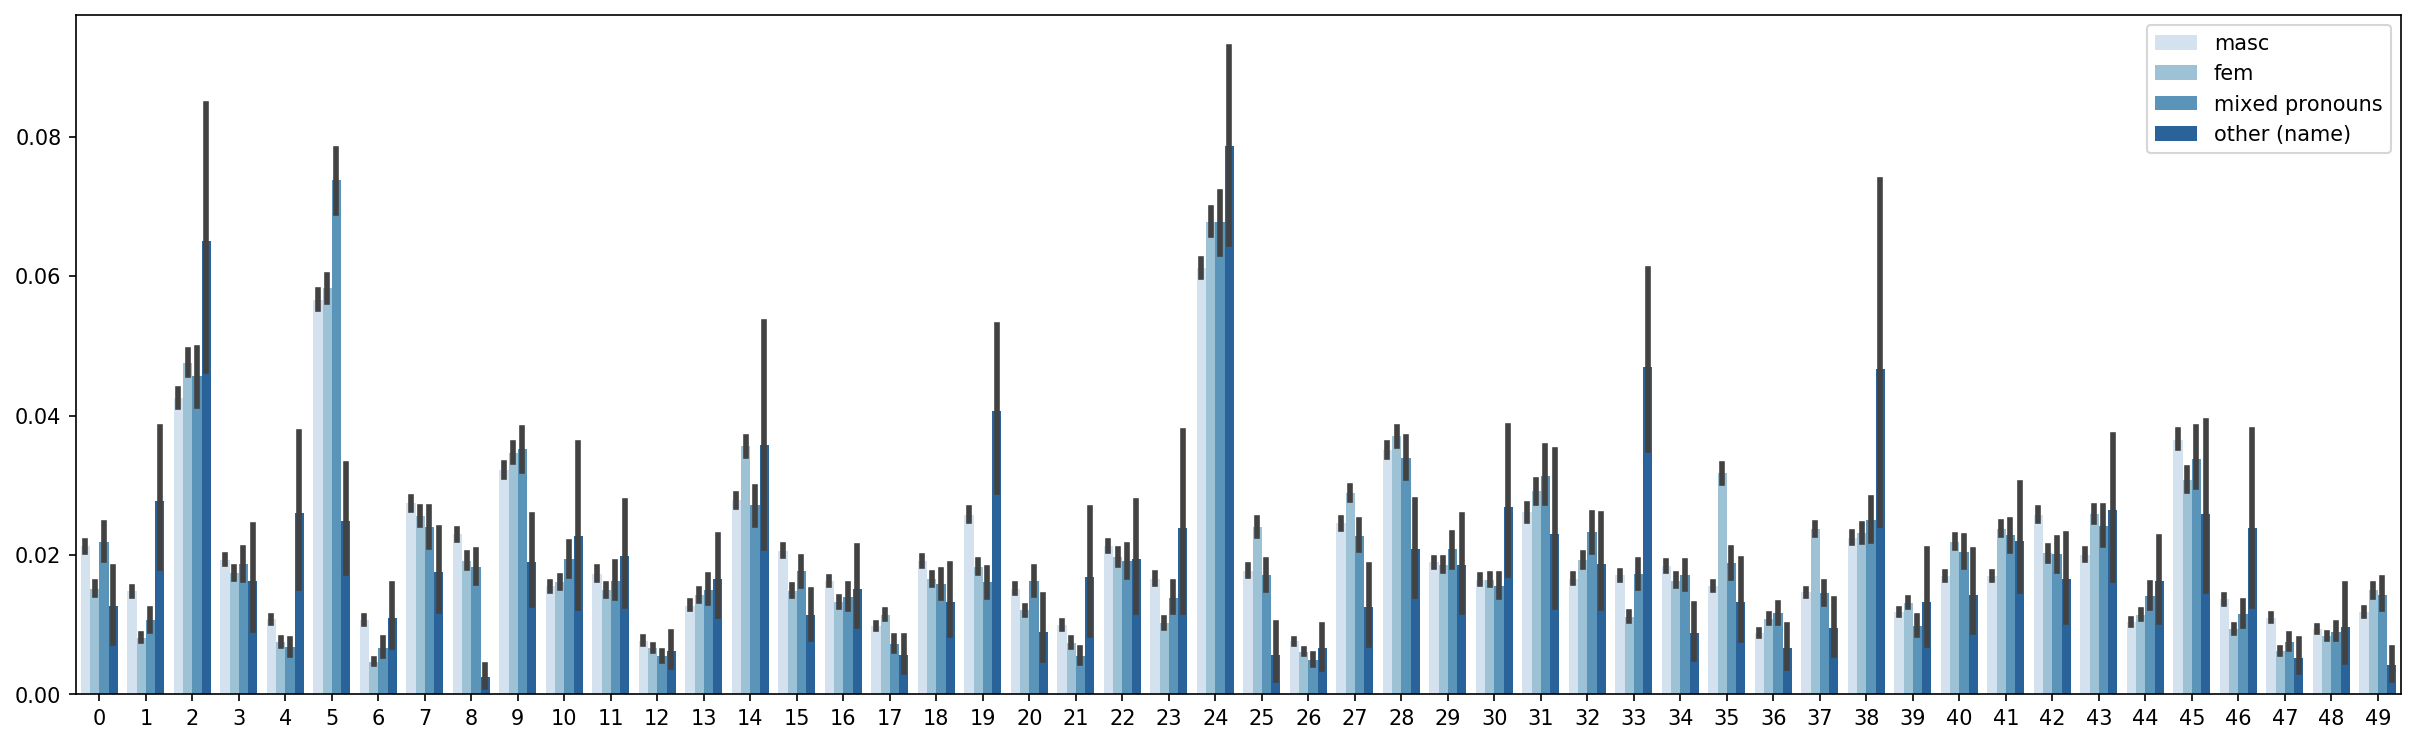

In [319]:
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Blues", hue="gender", data=orig_gender_topics)

In [351]:
gender_df = pd.DataFrame(gen_gender_topics)
gender_df = gender_df.groupby(['gender', 'topic']).mean()
gender_topic_dict = gender_df.to_dict('index')
diffs = {'dataset':[], 'diff':[], 'topic':[]}
gen_diffs = {}
for key in gender_topic_dict: 
    if key[0] == 'fem': 
        topic = key[1]
        fem_val = gender_topic_dict[key]['value']
        masc_val = gender_topic_dict[('masc', topic)]['value']
        diff = fem_val - masc_val
        diffs['dataset'].append('generated')
        diffs['diff'].append(diff)
        diffs['topic'].append(topic)
        gen_diffs[topic] = diff
        
gender_df = pd.DataFrame(orig_gender_topics)
gender_df = gender_df.groupby(['gender', 'topic']).mean()
gender_topic_dict = gender_df.to_dict('index')
orig_diffs = {}
for key in gender_topic_dict: 
    if key[0] == 'fem': 
        topic = key[1]
        fem_val = gender_topic_dict[key]['value']
        masc_val = gender_topic_dict[('masc', topic)]['value']
        diff = fem_val - masc_val
        diffs['dataset'].append('original')
        diffs['diff'].append(diff)
        diffs['topic'].append(topic)
        orig_diffs[topic] = diff
        
gender_df = pd.DataFrame(matched_gender_topics)
gender_df = gender_df.groupby(['gender', 'topic']).mean()
gender_topic_dict = gender_df.to_dict('index')
matched_diffs = {}
for key in gender_topic_dict: 
    if key[0] == 'fem': 
        topic = key[1]
        fem_val = gender_topic_dict[key]['value']
        masc_val = gender_topic_dict[('masc', topic)]['value']
        diff = fem_val - masc_val
        diffs['dataset'].append('matched')
        diffs['diff'].append(diff)
        diffs['topic'].append(topic)
        matched_diffs[topic] = diff

orig_diffs = [tup[1] for tup in sorted(orig_diffs.items(), key=lambda item: item[0])]
gen_diffs = [tup[1] for tup in sorted(gen_diffs.items(), key=lambda item: item[0])]
matched_diffs = [tup[1] for tup in sorted(matched_diffs.items(), key=lambda item: item[0])]

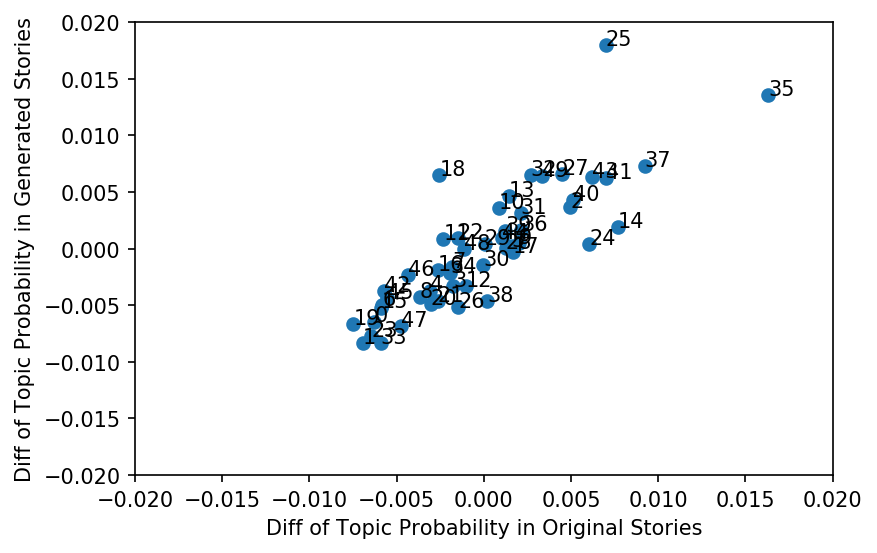

(0.8407233576402686, 2.1991009425878996e-14)


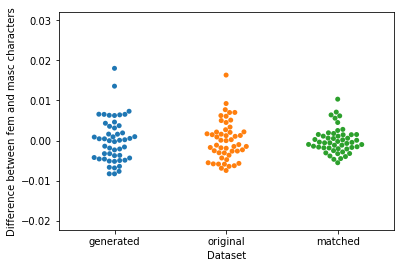

In [352]:
plt.figure(dpi=150)
plt.scatter(orig_diffs, gen_diffs)
for i, txt in enumerate([str(j) for j in range(50)]):
    plt.annotate(txt, (orig_diffs[i], gen_diffs[i]))
plt.ylim(-0.02, 0.02)
plt.xlim(-0.02, 0.02)
plt.xlabel("Diff of Topic Probability in Original Stories")
plt.ylabel("Diff of Topic Probability in Generated Stories")
plt.show()
print(pearsonr(orig_diffs, gen_diffs))
sns.swarmplot(x="dataset", y="diff", data=diffs)
plt.ylabel("Difference between fem and masc characters")
plt.xlabel("Dataset")
plt.show()

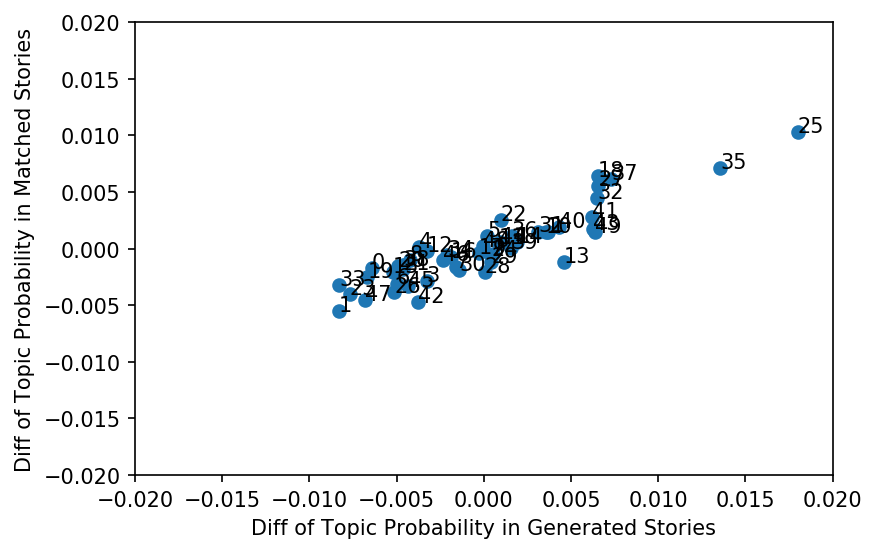

(0.9110054422353413, 4.2932167147894935e-20)


In [353]:
plt.figure(dpi=150)
plt.scatter(gen_diffs, matched_diffs)
for i, txt in enumerate([str(j) for j in range(50)]):
    plt.annotate(txt, (gen_diffs[i], matched_diffs[i]))
plt.ylim(-0.02, 0.02)
plt.xlim(-0.02, 0.02)
plt.xlabel("Diff of Topic Probability in Generated Stories")
plt.ylabel("Diff of Topic Probability in Matched Stories")
plt.show()
print(pearsonr(matched_diffs, gen_diffs))

In [354]:
print(np.argsort(orig_diffs))
print(np.sort(orig_diffs))

[19  1 23  0 33 15  6 42 45 47 46  8  4 20 16 21 18 11 34  7  3 22 26 48
 12 30 29 38 10 44 39 28 13  5 17  9 31 36 32 49 27  2 40 24 43 25 41 14
 37 35]
[-7.47554517e-03 -6.92074912e-03 -6.44507581e-03 -6.28564587e-03
 -5.90250207e-03 -5.87711886e-03 -5.82693694e-03 -5.70682330e-03
 -5.54666188e-03 -4.77578568e-03 -4.35726584e-03 -3.65721421e-03
 -3.09422365e-03 -3.05316551e-03 -2.65308354e-03 -2.63592881e-03
 -2.55565633e-03 -2.32451778e-03 -1.92949468e-03 -1.81962143e-03
 -1.73869639e-03 -1.48226236e-03 -1.47883979e-03 -1.15685707e-03
 -1.01991929e-03 -3.40638384e-05  6.72231453e-05  2.07496653e-04
  8.71951404e-04  1.04211898e-03  1.21390361e-03  1.25230630e-03
  1.45237293e-03  1.57931777e-03  1.67285719e-03  2.02936250e-03
  2.11695583e-03  2.15540083e-03  2.68664414e-03  3.35529543e-03
  4.49494324e-03  4.97238045e-03  5.09151351e-03  6.05183901e-03
  6.21977539e-03  6.98447461e-03  6.99969192e-03  7.69108236e-03
  9.22191573e-03  1.63228323e-02]


In [355]:
print(np.argsort(gen_diffs))
print(np.sort(gen_diffs))
print(np.sort(np.abs(gen_diffs)))
print(np.argsort(np.abs(gen_diffs)))

[33  1 23 47 19  0 15 26  6 20 38 21 45  8 42  4 12  3 46 34 16  7 30 17
 48 28  5 29 24  9 11 44 22 39 36 14 31 10  2 40 13 41 43 49 32 18 27 37
 35 25]
[-8.30901936e-03 -8.30203898e-03 -7.69635621e-03 -6.83981069e-03
 -6.68018445e-03 -6.43947003e-03 -5.20666452e-03 -5.12428921e-03
 -4.98801703e-03 -4.91053034e-03 -4.62743299e-03 -4.60509147e-03
 -4.36721071e-03 -4.24465690e-03 -3.77125400e-03 -3.70470734e-03
 -3.28239422e-03 -3.27770650e-03 -2.34771116e-03 -2.11340357e-03
 -1.88008845e-03 -1.61210106e-03 -1.41674172e-03 -2.77665420e-04
 -4.23083746e-05  5.83945360e-05  1.92981299e-04  4.19634059e-04
  4.32365441e-04  5.23706893e-04  8.56011734e-04  9.19468982e-04
  9.60788528e-04  1.57673325e-03  1.60148537e-03  1.89364307e-03
  3.12155810e-03  3.54147918e-03  3.69847666e-03  4.30353064e-03
  4.59946629e-03  6.23318895e-03  6.29029498e-03  6.39391732e-03
  6.51695968e-03  6.52948335e-03  6.55740251e-03  7.29376661e-03
  1.35534511e-02  1.79986662e-02]
[4.23083746e-05 5.83945360e-05 1

In [356]:
print(np.argsort(matched_diffs))
print(np.sort(matched_diffs))

[ 1 42 47 23 26 45 33  6  3 19 15 28 30 21  0  7 20 38 29 13  8 46 16 24
 34  9 17 12 39  4 48 11 14 44  5 36  2 49 10 31 43 40 22 41 32 27 37 18
 35 25]
[-5.54248196e-03 -4.69120498e-03 -4.51083511e-03 -4.00416853e-03
 -3.86018589e-03 -3.29019536e-03 -3.24308867e-03 -3.09014599e-03
 -2.85822684e-03 -2.52716434e-03 -2.10991670e-03 -2.04842377e-03
 -1.86625547e-03 -1.82108658e-03 -1.73174793e-03 -1.64913631e-03
 -1.55714042e-03 -1.42166738e-03 -1.17947874e-03 -1.15994865e-03
 -1.00315711e-03 -9.78533986e-04 -7.26398470e-04 -5.72082294e-04
 -5.71900897e-04 -4.66838524e-04 -4.02029745e-04 -2.34538297e-04
  5.88967980e-05  1.59549688e-04  2.46903489e-04  4.93958716e-04
  5.71360742e-04  6.04774233e-04  1.08234246e-03  1.08701142e-03
  1.43217986e-03  1.45453285e-03  1.49757389e-03  1.50435849e-03
  1.74748643e-03  1.92207480e-03  2.49696970e-03  2.77642843e-03
  4.48925079e-03  5.56640353e-03  6.14487014e-03  6.38045055e-03
  7.08874464e-03  1.03118573e-02]


In [21]:
gender_df = pd.DataFrame.from_dict(gender_topics)

In [23]:
topic_29 = gender_df[gender_df['topic'] == 29]
#topic_29['value']
topic_29

,gender,topic,value
29,masc,29,0.274048
79,masc,29,0.274048
129,masc,29,0.274048
179,masc,29,0.274048
229,masc,29,0.274048
...,...,...,...
2324779,masc,29,0.274048
2324829,masc,29,0.274048
2324879,masc,29,0.274048
2324929,masc,29,0.274048


### Effect of topic on story

In [7]:
with open(LOGS + 'topics_0.9/' + str(35) + '_prompt_topic_scores.json', 'r') as infile: 
    topic_score_dict1 = json.load(infile)
with open(LOGS + 'topics_0.9/' + str(33) + '_prompt_topic_scores.json', 'r') as infile: 
    topic_score_dict2 = json.load(infile)

In [72]:
def topic_main_char_percentage(): 
    masc_chars = defaultdict(set) # title : set of chars that are masc by pronouns
    fem_chars = defaultdict(set)
    neighbor_genders = defaultdict(list) # title_storyidx: [] 
    for f in os.listdir(LOGS + 'char_gender_0.9/'): 
        title = f.replace('.json', '')
        with open(LOGS + 'char_gender_0.9/' + f, 'r') as infile: 
            char_neighbors = json.load(infile)
        for char in char_neighbors: 
            # for every main character
            neighbor_dict = char_neighbors[char]
            for neighbor in neighbor_dict: 
                # for every character it co-occurs with 
                gender = neighbor['gender_label']
                neighbor_n = neighbor['character_name']
                pronoun_count = len(neighbor['gender'])
                story_ID = int(neighbor_n.split('_')[-1])
                if neighbor_n in topic_score_dict1[title]: 
                    # main character
                    if pronoun_count != 0 and gender == 'masc': 
                        masc_chars[title].add(neighbor_n)
                    if pronoun_count != 0 and gender == 'fem': 
                        fem_chars[title].add(neighbor_n)
                else: 
                    neighbor_genders[title + '_' + str(story_ID)].append(gender)
                        
    x1 = [] # fem topic probability
    y1 = [] # % of main characters are fem
    z1 = [] # average proportion of characters are fem
    x2 = [] # masc topic probability
    y2 = [] # % of main characters are masc
    z2 = [] # average proportion of characters are masc
    num_gens = 5
    for title in sorted(os.listdir(LOGS + 'original_prompts/')): 
        story_idx = 0
        with open(LOGS + 'original_prompts/' + title, 'r') as infile:
            for line in infile: 
                contents = line.strip().split('\t')
                char = contents[1]
                fem_values = []
                masc_values = []
                neighbor_masc_prop = []
                neighbor_fem_prop = []
                fem_count = 0
                masc_count = 0
                for i in range(story_idx, story_idx + num_gens): 
                    char_ID = char + '_' + str(i)
                    neighbors = neighbor_genders[title + '_' + str(i)]
                    if len(neighbors) > 0: 
                        neighbor_masc_prop.append(neighbors.count('masc') / len(neighbors))
                        neighbor_fem_prop.append(neighbors.count('fem') / len(neighbors))
                    else: 
                        neighbor_masc_prop.append(0)
                        neighbor_fem_prop.append(0)
                    fem_values.append(topic_score_dict1[title][char_ID])
                    masc_values.append(topic_score_dict2[title][char_ID])
                    if char_ID in fem_chars[title]: 
                        fem_count += 1
                    elif char_ID in masc_chars[title]: 
                        masc_count += 1
                x1.append(np.mean(fem_values)) 
                x2.append(np.mean(masc_values))
                y1.append(fem_count / float(num_gens)) 
                y2.append(masc_count / float(num_gens))
                z1.append(np.mean(neighbor_fem_prop))
                z2.append(np.mean(neighbor_masc_prop))
                story_idx += num_gens
    return x1, y1, z1, x2, y2, z2

In [73]:
x1, y1, z1, x2, y2, z2 = topic_main_char_percentage()

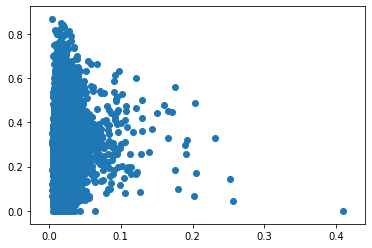

In [74]:
plt.scatter(x1, z1)

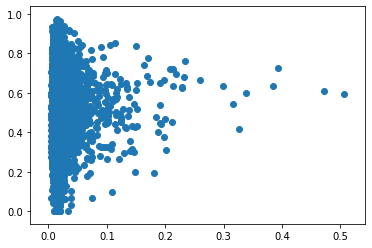

In [75]:
plt.scatter(x2, z2)

### Topic probability in prompt vs topic probability in document

In [115]:
def get_story_topics(): 
    '''
    returns a dictionary of 
    story_title_storyid : {topic_id : topic probability}
    '''
    topic_dir = LOGS + 'topics_0.9' 
    doc_topic_file = '%s/doc-topics.gz' % topic_dir
    doc_topics = open(doc_topic_file).read().splitlines() # list of topics
    story_ids = open(topic_dir + '/story_id_order').read().splitlines() # story IDs 
    story_topics = defaultdict(dict) # story ID : {topic id : value, topic id: value}
    for i, doc in enumerate(doc_topics): 
        contents = doc.split('\t')
        topics = [float(i) for i in contents[2:]]
        story_title_id = story_ids[i]
        if not story_title_id.startswith("ORIG_"):             
            assert len(topics) == 50
            for topic_id, value in enumerate(topics): 
                story_topics[story_title_id][topic_id] = value
    return story_topics

In [116]:
def effect_of_prompt_on_story(topic_id, topic_score_dict): 
    masc_chars = defaultdict(set) # title : set of chars that are masc by pronouns
    fem_chars = defaultdict(set)
    for f in os.listdir(LOGS + 'char_gender_0.9/'): 
        title = f.replace('.json', '')
        with open(LOGS + 'char_gender_0.9/' + f, 'r') as infile: 
            char_neighbors = json.load(infile)
        for char in char_neighbors: 
            # for every main character
            neighbor_dict = char_neighbors[char]
            for neighbor in neighbor_dict: 
                # for every character it co-occurs with 
                gender = neighbor['gender_label']
                neighbor_n = neighbor['character_name']
                pronoun_count = len(neighbor['gender'])
                story_ID = int(neighbor_n.split('_')[-1])
                if neighbor_n in topic_score_dict[title]: 
                    # main character
                    if gender == 'masc': 
                        masc_chars[title].add(neighbor_n)
                    if gender == 'fem': 
                        fem_chars[title].add(neighbor_n)
    story_topics = get_story_topics()
    x = []
    y = []
    z = []
    for title in topic_score_dict: 
        for char_ID in topic_score_dict[title]: 
            story_ID = int(char_ID.split('_')[-1])
            prompt_prob = topic_score_dict[title][char_ID]
            story_title_id = title + str(story_ID + 1)
            topic_dict = story_topics[story_title_id]
            story_prob = topic_dict[topic_id] 
            x.append(prompt_prob)
            y.append(story_prob)
            if char_ID in masc_chars[title]: 
                z.append('masc')
            elif char_ID in fem_chars[title]: 
                z.append('fem')
            else: 
                z.append('other')
    return x, y, z

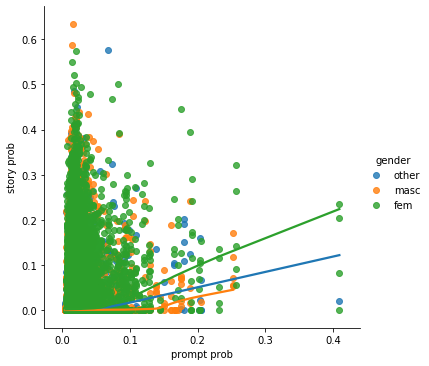

In [10]:
x, y, z = effect_of_prompt_on_story(35, topic_score_dict1)
prob_d = {'prompt prob': x, 'story prob': y, 'gender': z}
prob_df = pd.DataFrame.from_dict(prob_d)
sns.lmplot(x="prompt prob", y="story prob", hue='gender', data=prob_df, lowess=True)
plt.show()

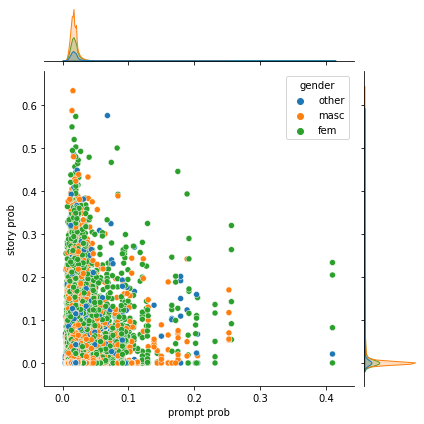

In [22]:
x, y, z = effect_of_prompt_on_story(35, topic_score_dict1)
prob_d = {'prompt prob': x, 'story prob': y, 'gender': z}
prob_df = pd.DataFrame.from_dict(prob_d)
g = sns.jointplot(data=prob_df, x="prompt prob", y="story prob", hue="gender")
plt.show()

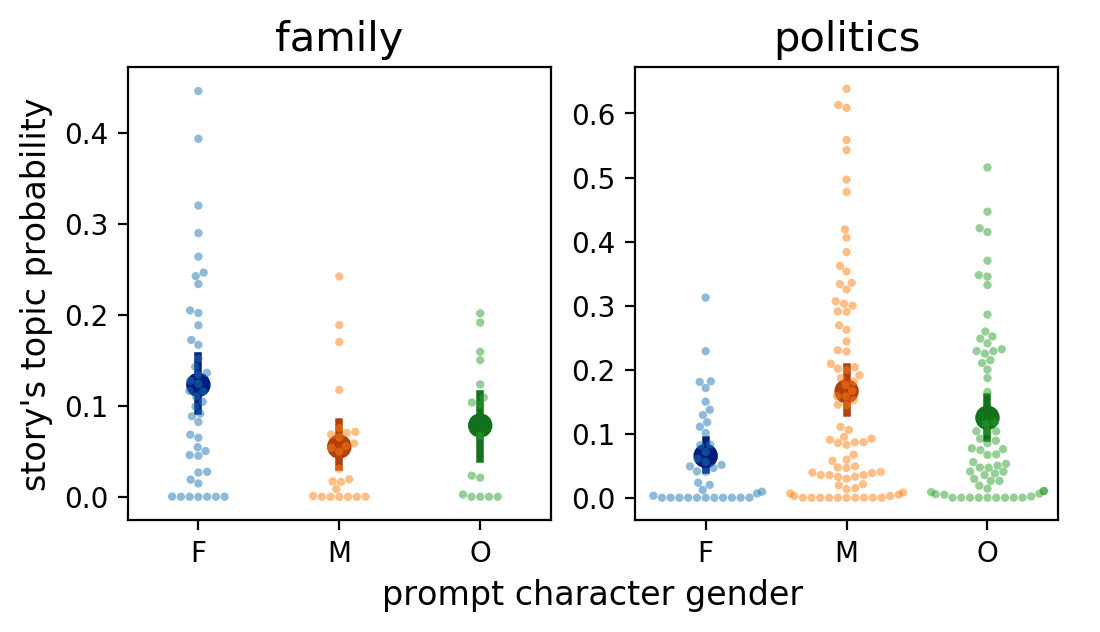

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("prompt character gender", fontsize=12)
plt.ylabel("story\'s topic probability", fontsize=12)

x, y, z = effect_of_prompt_on_story(35, topic_score_dict1)
prob_d = {'prompt prob': x, 'story prob': y, 'gender': z}
prob_df = pd.DataFrame.from_dict(prob_d)
prob_df = prob_df[prob_df['prompt prob'] > 0.15]
sns.swarmplot(ax=axes[0], x="gender", y="story prob", data=prob_df, alpha=.5, size=3, order=['fem', 'masc', 'other'])
sns.pointplot(ax=axes[0], x="gender", y="story prob",
              data=prob_df, join=False, palette="dark", order=['fem', 'masc', 'other'])
axes[0].get_xaxis().set_ticklabels(['F', 'M', 'O'])
axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[0].set_title('family', fontsize=15)

x, y, z = effect_of_prompt_on_story(33, topic_score_dict2)
prob_d = {'prompt prob': x, 'story prob': y, 'gender': z}
prob_df = pd.DataFrame.from_dict(prob_d)
prob_df = prob_df[prob_df['prompt prob'] > 0.15]
sns.swarmplot(ax=axes[1], x="gender", y="story prob", data=prob_df, alpha=.5, size=3, order=['fem', 'masc', 'other'])
sns.pointplot(ax=axes[1], x="gender", y="story prob",
              data=prob_df, join=False, palette="dark", order=['fem', 'masc', 'other'])
axes[1].get_xaxis().set_ticklabels(['F', 'M', 'O'])
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_title('politics', fontsize=15)
plt.show()

In [35]:
x, y, z = effect_of_prompt_on_story(35, topic_score_dict1)
print(pearsonr(x, y))
print(np.percentile(x, 99.9))

(0.11714909591740269, 0.0)
0.12992424242423078


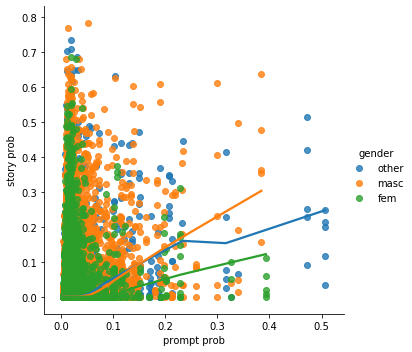

In [115]:
x, y, z = effect_of_prompt_on_story(33, topic_score_dict2)
prob_d = {'prompt prob': x, 'story prob': y, 'gender': z}
prob_df = pd.DataFrame.from_dict(prob_d)
sns.lmplot(x="prompt prob", y="story prob", hue='gender', data=prob_df, lowess=True)
plt.show()

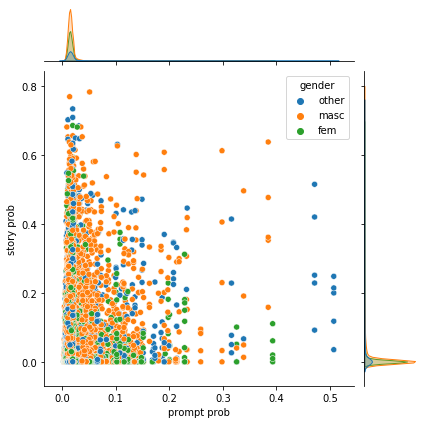

In [21]:
x, y, z = effect_of_prompt_on_story(33, topic_score_dict2)
prob_d = {'prompt prob': x, 'story prob': y, 'gender': z}
prob_df = pd.DataFrame.from_dict(prob_d)
g = sns.jointplot(data=prob_df, x="prompt prob", y="story prob", hue="gender")
plt.show()

## Lexicons

In [72]:
def read_stereotypes(): 
    inpath = '/mnt/data0/corpora/lexicons/fast_icwsm_2016_gender_stereotypes.csv'
    labels = set(['weak', 'dependent', 'submissive', 'afraid', 'strong', 'dominant', 'beautiful', 'sexual'])
    lexicons = defaultdict(set)
    with open(inpath, 'r') as infile: 
        reader = csv.DictReader(infile, delimiter=',')
        for row in reader: 
            for key in row:
                if row[key] == '': continue 
                if key in labels: 
                    lexicons[key].add(row[key])
    inpath = '/mnt/data0/corpora/lexicons/empath_categories.tsv'
    with open(inpath, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('\t')
            if 'intellectual' in contents: 
                for w in contents: 
                    lexicons['intellectual'].add(w)
    for key in lexicons: 
        lexicons[key].add(key)
        
    axes_A1 = ['strong', 'dominant']
    axes_A2 = ['weak', 'dependent', 'submissive', 'afraid']
    axes_B1 = ['beautiful', 'sexual']
    axes_B2 = ['intellectual']
    lexicon_d  = defaultdict(set)
    lexicon_d['strong'] = lexicons['strong'] | lexicons['dominant']
    for cat in axes_A2: 
        lexicon_d['weak'] |= lexicons[cat]
    lexicon_d['physical'] = lexicons['beautiful'] | lexicons['sexual']
    lexicon_d['intellectual'] = lexicons['intellectual']
    return lexicon_d

In [73]:
lexicon_d = read_stereotypes()

In [74]:
for k in lexicon_d: print(k, len(lexicon_d[k]))

strong 113
weak 141
physical 201
intellectual 98


### Word counts

In [75]:
genpath = LOGS + 'generated_adj_noun/'
frames = []
d = {'gender':[], 'lexicon':[], 'value':[], 'story':[]}
word_counts = defaultdict(Counter) # (gender, lexicon) : word : count
for f in os.listdir(genpath):
    title = f.replace('.tokens', '')
    gen_word = Counter() # (gender, lexicon, storyid) : count 
    total_counts = Counter() # (gender, storyid) : count
    with open(genpath + f, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('\t')
            w = contents[0]
            deprel = contents[3]
            hw = contents[5]
            storyid = contents[7]
            gender = contents[8]
            if deprel == 'amod': 
                keyword = w
            elif deprel == 'nsubj': 
                keyword = hw
            total_counts[(gender, storyid)] += 1
            for k in lexicon_d: 
                if keyword in lexicon_d[k]: 
                    gen_word[(gender, k, storyid)] += 1
                    word_counts[(gender, k)][keyword] += 1
    for k in gen_word: 
        gender, lexicon, storyid = k
        frac = gen_word[k] / float(total_counts[(gender, storyid)])
        d['gender'].append(gender)
        d['lexicon'].append(lexicon)
        d['value'].append(frac)
        d['story'].append(title + '_' + storyid)

In [76]:
df = pd.DataFrame.from_dict(d)
df

,gender,lexicon,value,story
0,masc,weak,0.038462,deeping_the_bridge_of_desire_6
1,fem,weak,0.021739,deeping_the_bridge_of_desire_7
2,fem,physical,0.021739,deeping_the_bridge_of_desire_7
3,fem,strong,0.021739,deeping_the_bridge_of_desire_7
4,masc,weak,0.047619,deeping_the_bridge_of_desire_11
...,...,...,...,...
58945,fem,physical,0.200000,cliff_no_telephone_to_heaven_96
58946,fem,physical,0.018182,cliff_no_telephone_to_heaven_97
58947,fem,strong,0.034483,cliff_no_telephone_to_heaven_98
58948,fem,physical,0.068966,cliff_no_telephone_to_heaven_98


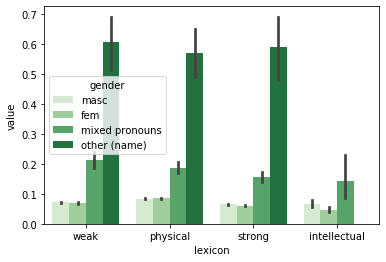

In [77]:
sns.barplot(x="lexicon", y="value", palette="Greens", hue="gender", data=df)

In [78]:
for k in word_counts: 
    print(k, '.........', word_counts[k].most_common(10))

('masc', 'weak') ......... [('afraid', 1484), ('need', 1208), ('old', 640), ('tired', 504), ('sorry', 392), ('fallen', 372), ('sick', 355), ('willing', 350), ('worried', 335), ('married', 316)]
('fem', 'weak') ......... [('afraid', 1527), ('need', 928), ('old', 477), ('tired', 446), ('sick', 302), ('married', 302), ('sorry', 281), ('worried', 275), ('nervous', 268), ('fallen', 263)]
('fem', 'physical') ......... [('wanted', 9216), ('feel', 3022), ('able', 2063), ('like', 1062), ('believe', 940), ('good', 531), ('beautiful', 450), ('young', 393), ('keep', 379), ('pregnant', 282)]
('fem', 'strong') ......... [('feel', 3022), ('sure', 2699), ('able', 2063), ('keep', 379), ('strong', 212), ('hurt', 201), ('smart', 153), ('prepared', 119), ('tall', 95), ('fit', 69)]
('masc', 'strong') ......... [('sure', 3922), ('feel', 3653), ('able', 3070), ('keep', 556), ('hurt', 369), ('strong', 257), ('smart', 196), ('prepared', 185), ('tall', 168), ('big', 134)]
('masc', 'physical') ......... [('wante

### Similarity scores

In [79]:
with open(LOGS + 'intellect_scores.json', 'r') as infile: 
    intellect_scores = Counter(json.load(infile))
print(intellect_scores.most_common(20), '\n')
with open(LOGS + 'physical_scores.json', 'r') as infile: 
    physical_scores = Counter(json.load(infile))
print(physical_scores.most_common(20), '\n')
with open(LOGS + 'strength_scores.json', 'r') as infile: 
    strength_scores = Counter(json.load(infile))
sorted_strength = strength_scores.most_common()
print(sorted_strength[:20], '\n')
print(sorted_strength[-20:], '\n')

[('intellectual', 0.565263569355011), ('aesthetic', 0.531465470790863), ('moral', 0.5274004936218262), ('artistic', 0.5271057486534119), ('progressive', 0.5259044766426086), ('values', 0.5202677249908447), ('spiritual', 0.5173299312591553), ('secular', 0.5044122338294983), ('religious', 0.500640332698822), ('imaginative', 0.5004410147666931), ('scientific', 0.4996270537376404), ('marxist', 0.49501365423202515), ('revolutionary', 0.49355006217956543), ('political', 0.49316367506980896), ('radical', 0.4918311834335327), ('creative', 0.49179786443710327), ('academic', 0.49019569158554077), ('metaphysical', 0.4863678812980652), ('fanatical', 0.48373615741729736), ('humanitarian', 0.4801952838897705)] 

[('sensual', 0.29684576392173767), ('beautiful', 0.2961128056049347), ('gorgeous', 0.29289957880973816), ('flawless', 0.2922338545322418), ('manly', 0.2828841209411621), ('charming', 0.2827223837375641), ('seductive', 0.28182563185691833), ('womanly', 0.28101828694343567), ('enticing', 0.281

### Generated

In [87]:
def get_lexicon_dict(genpath): 
    d = {'gender':[], 'lexicon':[], 'value':[]}
    for f in os.listdir(genpath):
        title = f.replace('.tokens', '')
        gen_word = Counter() # (gender, lexicon) : value
        with open(genpath + f, 'r') as infile: 
            for line in infile: 
                contents = line.strip().split('\t')
                w = contents[0]
                deprel = contents[3]
                hw = contents[5]
                storyid = contents[7]
                gender = contents[8]
                if deprel == 'amod': 
                    keyword = w
                elif deprel == 'nsubj': 
                    keyword = hw
                for k in lexicon_d: 
                    if keyword in intellect_scores: 
                        d['gender'].append(gender)
                        d['lexicon'].append('intellectual')
                        d['value'].append(intellect_scores[keyword])
                for k in lexicon_d: 
                    if keyword in physical_scores: 
                        d['gender'].append(gender)
                        d['lexicon'].append('physical')
                        d['value'].append(physical_scores[keyword])
                for k in lexicon_d: 
                    if keyword in strength_scores: 
                        d['gender'].append(gender)
                        d['lexicon'].append('power')
                        d['value'].append(strength_scores[keyword])
    return d

In [88]:
gen_d = get_lexicon_dict(LOGS + 'generated_adj_noun/')
gen_df = pd.DataFrame.from_dict(gen_d)
gen_df

,gender,lexicon,value
0,masc,intellectual,0.041816
1,masc,intellectual,0.041816
2,masc,intellectual,0.041816
3,masc,intellectual,0.041816
4,masc,physical,0.003559
...,...,...,...
22639399,fem,physical,-0.039087
22639400,fem,power,-0.184128
22639401,fem,power,-0.184128
22639402,fem,power,-0.184128


In [93]:
stats = gen_df.groupby(['gender', 'lexicon']).agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)

                                value                      ci95_hi   ci95_lo
                                 mean    count       std                    
gender         lexicon                                                      
fem            intellectual -0.003291  2905812  0.105950 -0.003169 -0.003413
               physical      0.030459  2905812  0.049286  0.030515  0.030402
               power        -0.115784  2905812  0.141006 -0.115622 -0.115947
masc           intellectual -0.004574  4437828  0.107137 -0.004474 -0.004673
               physical      0.027935  4437828  0.047519  0.027979  0.027891
               power        -0.107029  4437828  0.141524 -0.106897 -0.107161
mixed pronouns intellectual -0.023121   171084  0.097400 -0.022660 -0.023583
               physical      0.027747   171084  0.043793  0.027954  0.027539
               power        -0.145053   171084  0.135541 -0.144410 -0.145695
other (name)   intellectual -0.002443    31744  0.100432 -0.001338 -0.003547

In [83]:
fem_intell = gen_df.loc[(gen_df.gender == 'fem') & (gen_df.lexicon =='intellectual')]['value'].to_list()
masc_intell = gen_df.loc[(gen_df.gender == 'masc') & (gen_df.lexicon =='intellectual')]['value'].to_list()
print(mannwhitneyu(fem_intell, masc_intell, alternative="less"))
fem_phy = gen_df.loc[(gen_df.gender == 'fem') & (gen_df.lexicon =='physical')]['value'].to_list()
masc_phy = gen_df.loc[(gen_df.gender == 'masc') & (gen_df.lexicon =='physical')]['value'].to_list()
print(mannwhitneyu(fem_phy, masc_phy, alternative="greater"))
fem_power = gen_df.loc[(gen_df.gender == 'fem') & (gen_df.lexicon =='power')]['value'].to_list()
masc_power = gen_df.loc[(gen_df.gender == 'masc') & (gen_df.lexicon =='power')]['value'].to_list()
print(mannwhitneyu(fem_power, masc_power, alternative="less"))

MannwhitneyuResult(statistic=6510619490392.0, pvalue=1.0)
MannwhitneyuResult(statistic=6614628332384.0, pvalue=0.0)
MannwhitneyuResult(statistic=6263250727880.0, pvalue=0.0)


### Matched

In [94]:
gen_d = get_lexicon_dict(LOGS + 'matched_adj_noun/')
gen_df = pd.DataFrame.from_dict(gen_d)
gen_df

,gender,lexicon,value
0,masc,intellectual,-0.040177
1,masc,intellectual,-0.040177
2,masc,intellectual,-0.040177
3,masc,intellectual,-0.040177
4,masc,physical,0.017319
...,...,...,...
1576375,fem,physical,0.008737
1576376,fem,power,-0.089041
1576377,fem,power,-0.089041
1576378,fem,power,-0.089041


In [95]:
stats = gen_df.groupby(['gender', 'lexicon']).agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)

                                value                     ci95_hi   ci95_lo
                                 mean   count       std                    
gender         lexicon                                                     
fem            intellectual -0.005387  264176  0.105975 -0.004983 -0.005792
               physical      0.029558  264176  0.048595  0.029743  0.029373
               power        -0.115504  264176  0.141492 -0.114964 -0.116043
masc           intellectual -0.004404  261124  0.107003 -0.003994 -0.004815
               physical      0.028003  261124  0.047211  0.028184  0.027822
               power        -0.107016  261124  0.142575 -0.106470 -0.107563
mixed pronouns intellectual  0.042784     160  0.103240  0.058782  0.026787
               physical      0.030017     160  0.063339  0.039831  0.020202
               power        -0.052699     160  0.128094 -0.032850 -0.072547


### Original books

In [90]:
d = get_lexicon_dict(LOGS + 'orig_adj_noun/')

In [91]:
df = pd.DataFrame.from_dict(d)
stats = df.groupby(['gender', 'lexicon']).agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)

                                value                      ci95_hi   ci95_lo
                                 mean    count       std                    
gender         lexicon                                                      
fem            intellectual  0.005537   672704  0.110466  0.005801  0.005273
               physical      0.032021   672704  0.051223  0.032144  0.031899
               power        -0.097128   672704  0.147259 -0.096776 -0.097480
masc           intellectual  0.002400  1147348  0.110933  0.002603  0.002197
               physical      0.029314  1147348  0.049366  0.029405  0.029224
               power        -0.091126  1147348  0.146980 -0.090857 -0.091395
mixed pronouns intellectual -0.005971    33308  0.109559 -0.004794 -0.007147
               physical      0.029642    33308  0.050292  0.030182  0.029102
               power        -0.106689    33308  0.149226 -0.105086 -0.108291
other (name)   intellectual -0.032961      632  0.102484 -0.024971 -0.040952

In [86]:
fem_intell = df.loc[(df.gender == 'fem') & (df.lexicon =='intellectual')]['value'].to_list()
masc_intell = df.loc[(df.gender == 'masc') & (df.lexicon =='intellectual')]['value'].to_list()
print(mannwhitneyu(fem_intell, masc_intell, alternative="less"))
fem_phy = df.loc[(df.gender == 'fem') & (df.lexicon =='physical')]['value'].to_list()
masc_phy = df.loc[(df.gender == 'masc') & (df.lexicon =='physical')]['value'].to_list()
print(mannwhitneyu(fem_phy, masc_phy, alternative="greater"))
fem_power = df.loc[(df.gender == 'fem') & (df.lexicon =='power')]['value'].to_list()
masc_power = df.loc[(df.gender == 'masc') & (df.lexicon =='power')]['value'].to_list()
print(mannwhitneyu(fem_power, masc_power, alternative="less"))

MannwhitneyuResult(statistic=393077533872.0, pvalue=1.0)
MannwhitneyuResult(statistic=396569307336.0, pvalue=1.9790824824120187e-213)
MannwhitneyuResult(statistic=379178858432.0, pvalue=1.3407034764697041e-86)


**Sorry for no plots!!!!!**

### Intellectual

**generated**

fem: -0.003291 (+0.001)

masc: -0.004574

**matched**

fem: -0.005387 (-0.001)

masc: -0.004404

**books**

fem: 0.005537 (+ 0.003)

masc: 0.002400

### Appearance 

**generated**

fem: 0.030459 (+0.003)

masc: 0.027935

**matched**

fem: 0.029558 (+0.001)

masc: 0.028003 

**books** 

fem: 0.032021 (+0.003)

masc: 0.029314 

### Power

**generated**

fem: -0.115784 (-0.008)

masc: -0.107029

**matched**

fem: -0.115504 (-0.008)

masc: -0.107016

**books**

fem: -0.097128 (-0.006)

masc: -0.091126

### Anti-stereotype

In [110]:
def get_anti_stereotype_prompts(prompt_design_verbs, verb_type, genpath): 
    title_storyidx = set()
    for title_charID in prompt_design_verbs[verb_type]: 
        contents = title_charID.split('#')
        title = contents[0]
        storyidx = contents[1].split('_')[-1]
        title_storyidx.add((title, storyidx))
    d = {'gender':[], 'lexicon':[], 'value':[]}
    for f in os.listdir(genpath):
        title = f.replace('.tokens', '')
        gen_word = Counter() # (gender, lexicon) : value
        with open(genpath + f, 'r') as infile: 
            for line in infile: 
                contents = line.strip().split('\t')
                w = contents[0]
                deprel = contents[3]
                hw = contents[5]
                storyid = contents[7]
                gender = contents[8]
                if (title, storyid) not in title_storyidx: 
                    continue
                if deprel == 'amod': 
                    keyword = w
                elif deprel == 'nsubj': 
                    keyword = hw
                for k in lexicon_d: 
                    if keyword in intellect_scores: 
                        d['gender'].append(gender)
                        d['lexicon'].append('intellectual')
                        d['value'].append(intellect_scores[keyword])
                for k in lexicon_d: 
                    if keyword in physical_scores: 
                        d['gender'].append(gender)
                        d['lexicon'].append('physical')
                        d['value'].append(physical_scores[keyword])
                for k in lexicon_d: 
                    if keyword in strength_scores: 
                        d['gender'].append(gender)
                        d['lexicon'].append('power')
                        d['value'].append(strength_scores[keyword])
    return d

In [99]:
with open(LOGS + 'prompt_design_verbs.json', 'r') as infile: 
    prompt_design_verbs = json.load(infile)

In [111]:
gen_d = get_anti_stereotype_prompts(prompt_design_verbs, 'power', LOGS + 'generated_adj_noun/')
gen_df = pd.DataFrame.from_dict(gen_d)
gen_df

,gender,lexicon,value
0,masc,intellectual,-0.154434
1,masc,intellectual,-0.154434
2,masc,intellectual,-0.154434
3,masc,intellectual,-0.154434
4,masc,physical,-0.053362
...,...,...,...
4872811,fem,physical,0.050681
4872812,fem,power,-0.224946
4872813,fem,power,-0.224946
4872814,fem,power,-0.224946


In [112]:
stats = gen_df.groupby(['gender', 'lexicon']).agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)

                                value                     ci95_hi   ci95_lo
                                 mean   count       std                    
gender         lexicon                                                     
fem            intellectual -0.005101  586552  0.106387 -0.004829 -0.005373
               physical      0.029423  586552  0.049044  0.029549  0.029298
               power        -0.111425  586552  0.141129 -0.111064 -0.111787
masc           intellectual -0.007165  994592  0.107617 -0.006953 -0.007376
               physical      0.026598  994592  0.047325  0.026691  0.026505
               power        -0.102490  994592  0.141514 -0.102212 -0.102768
mixed pronouns intellectual -0.027261   35816  0.099679 -0.026229 -0.028294
               physical      0.025636   35816  0.044176  0.026094  0.025179
               power        -0.132381   35816  0.138002 -0.130952 -0.133810
other (name)   intellectual  0.002316    7312  0.109842  0.004834 -0.000201
            

In [113]:
gen_d = get_anti_stereotype_prompts(prompt_design_verbs, 'cognitive', LOGS + 'generated_adj_noun/')
gen_df = pd.DataFrame.from_dict(gen_d)
gen_df

,gender,lexicon,value
0,masc,intellectual,-0.095945
1,masc,intellectual,-0.095945
2,masc,intellectual,-0.095945
3,masc,intellectual,-0.095945
4,masc,physical,0.041097
...,...,...,...
262039,fem,physical,0.015293
262040,fem,power,-0.004867
262041,fem,power,-0.004867
262042,fem,power,-0.004867


In [114]:
stats = gen_df.groupby(['gender', 'lexicon']).agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)

                                value                    ci95_hi   ci95_lo
                                 mean  count       std                    
gender         lexicon                                                    
fem            intellectual  0.011318  30720  0.107857  0.012525  0.010112
               physical      0.033058  30720  0.049031  0.033607  0.032510
               power        -0.106462  30720  0.143412 -0.104858 -0.108065
masc           intellectual  0.007957  54640  0.109987  0.008879  0.007035
               physical      0.028057  54640  0.047491  0.028455  0.027659
               power        -0.092775  54640  0.148163 -0.091533 -0.094018
mixed pronouns intellectual -0.008459   1640  0.110239 -0.003123 -0.013794
               physical      0.031487   1640  0.043829  0.033609  0.029366
               power        -0.111506   1640  0.151623 -0.104167 -0.118844
other (name)   intellectual  0.108418    348  0.105719  0.119526  0.097311
               physical  